# **Fotografia de alta faixa dinâmica e mapeamento de tons**

* Instale um aplicativo de celular que permita a configuração manual no celular (não precisa ser pago, existem versões gratuitas com as ferramentas básicas de alteração de ISO e velocidade do obturador.
Dica do Android: DSLR de câmera manual (Lite)
Dica IOS: câmera manual
*  Tire 3 fotos de um ambiente com iluminação normal, mas diminuindo a exposição da câmera.
* Valores sugeridos de ISO e velocidade do obturador (SS):

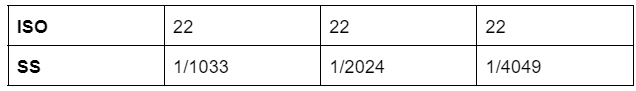

* Tire 3 fotos de um ambiente com iluminação normal, mas aumentando a exposição da câmera.
* Valores sugeridos de ISO e velocidade do obturador (SS):


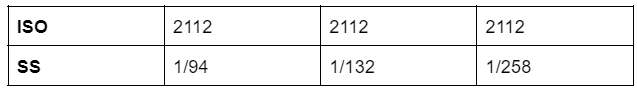

## Importing test images

In [ ]:
!git clone https://github.com/kevinruiz182/iqa_img_storage.git

In [ ]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

def open_rgb_img(img_src):
  im_cv = cv2.imread(img_src, cv2.IMREAD_UNCHANGED)
  return cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

Câmeras móveis pequenas têm uma faixa dinâmica limitada, capturando apenas uma faixa estreita de intensidades de luz. Intensidades fora desta faixa parecem muito escuras ou muito claras, perdendo detalhes.

Para neutralizar isso, ajustar o tempo de exposição pode alterar o alcance para capturar melhor os detalhes. No entanto, isso não é perfeito e os detalhes ainda podem ser perdidos.

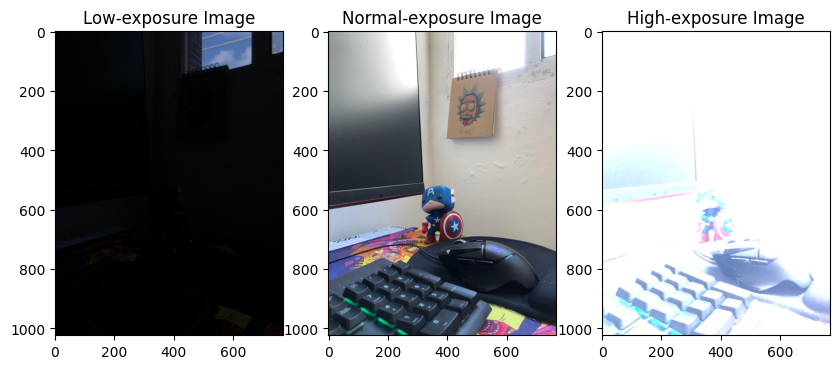

In [ ]:
#Plot the low-light image and the one with high-exposure
fig = plt.figure(figsize=(10,10))
columns = 3
rows = 1

high_img = open_rgb_img('iqa_img_storage/iqa/distortions/hdr/high_exposed/94.jpeg')
normal_img = open_rgb_img('iqa_img_storage/iqa/distortions/hdr/normal.jpeg')
low_img = open_rgb_img('iqa_img_storage/iqa/distortions/hdr/low_exposed/4049.jpeg')

ax = []
ax.append(fig.add_subplot(rows, columns, 1))
ax[-1].set_title("Low-exposure Image")
plt.imshow(low_img)

ax.append(fig.add_subplot(rows, columns, 2))
ax[-1].set_title("Normal-exposure Image")
plt.imshow(normal_img)

ax.append(fig.add_subplot(rows, columns, 3))
ax[-1].set_title("High-exposure Image")
plt.imshow(high_img)

plt.show()

Paul Debevec e sua equipe propuseram um [método](https://www.pauldebevec.com/Research/HDR/debevec-siggraph97.pdf) para capturar cenas com exposições variadas:

*   Configurar:
  *   Capture múltiplas imagens estáticas da mesma cena com diferentes tempos de exposição.
  
  Garantir:

  *   A câmera permanece estacionária (usando um tripé ou suporte).
  *   Controle manual do tempo de exposição para evitar ajustes automáticos.
  *   O número de fotos tiradas depende da faixa de intensidade da imagem, começando com pelo menos três. Certifique-se de que os tempos de exposição variam o suficiente para que os detalhes desejados fiquem nítidos em pelo menos uma imagem.

*   Aplicação do Algoritmo: Utilizando as imagens, reconstrua a curva de resposta da câmera. Isso cria uma relação entre:

  * Brilho do mundo real em um ponto.
  *   Período de exposição.
  * Valor do pixel na imagem resultante.
*   Implementação: Utilize o método Debevec disponível na biblioteca OpenCV para este processo.

In [ ]:
high_folder = 'iqa_img_storage/iqa/distortions/hdr/high_exposed'
low_folder = 'iqa_img_storage/iqa/distortions/hdr/low_exposed'

# We get all the image files from the source folder
high_files = list([os.path.join(high_folder, f) for f in os.listdir(high_folder)])
low_files = list([os.path.join(low_folder, f) for f in os.listdir(low_folder)])

all_files = sorted(low_files + high_files)

hdr_images = list([open_rgb_img(f) for f in all_files])
# Compute the exposure times in seconds
exposures = np.float32([1. / t for t in [132, 258, 94, 1033, 2024, 4049]])

# Compute the response curve
calibration = cv2.createCalibrateDebevec()
response = calibration.process(hdr_images, exposures)

## Compute the HDR image

In [ ]:
merge = cv2.createMergeDebevec()
hdr = merge.process(hdr_images, exposures, response)

## Tone-mapping

Embora os displays típicos utilizem canais de valor de byte (0-255), ainda é possível aproveitar a riqueza do mapa de irradiância. Essa adaptação é conhecida como mapeamento de tons, que converte os extensos valores do mapa de irradiância de ponto flutuante em imagens de valores de bytes padrão. Várias técnicas podem preservar muitos detalhes durante esta conversão. Por exemplo, ao aumentar a nitidez das bordas da imagem HDR antes da conversão, esses detalhes também podem ser retidos na versão com faixa dinâmica inferior.

In [ ]:
durand = cv2.createTonemap(2.5)
ldr = durand.process(hdr)

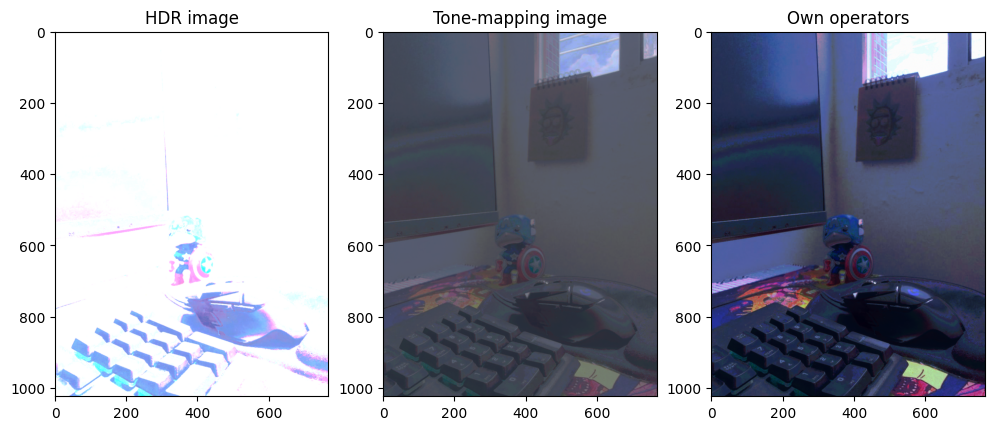

In [ ]:
def countTonemap(hdr, min_fraction=0.0005):
  counts, ranges = np.histogram(hdr, 256)
  min_count = min_fraction * hdr.size
  delta_range = ranges[1] - ranges[0]

  image = hdr.copy()
  for i in range(len(counts)):
      if counts[i] < min_count:
          image[image >= ranges[i + 1]] -= delta_range
          ranges -= delta_range

  return cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)

tonemap = countTonemap(hdr)

#Plot the result
# Tonemap operators create floating point images with values in the 0..1 range
# This is why we multiply the image with 255 before saving
fig = plt.figure(figsize=(12,12))
columns = 3
rows = 1

ax.append(fig.add_subplot(rows, columns, 1))
ax[-1].set_title("HDR image")
plt.imshow(hdr/255)

ax.append(fig.add_subplot(rows, columns, 2))
ax[-1].set_title("Tone-mapping image")
plt.imshow(ldr)

ax.append(fig.add_subplot(rows, columns, 3))
ax[-1].set_title("Own operators")
plt.imshow(tonemap)

plt.show()

**References**
    
*   Intro to Python Image Processing in Computational Photography

    https://www.toptal.com/opencv/python-image-processing-in-computational-photography


*   Método de Paul Debevec e sua equipe.

    https://www.pauldebevec.com/Research/HDR/debevec-siggraph97.pdf

